Notebook for Xander HR Analytics Exercise.

Datasets imported both via PostgreSQL(main tables) and directly from csv(in_time and out_time).

Data inspected for type, null values, distribution (histograms). In_time and out_time aggregated for attendance (count) and mean_hours worked.

For initial modelling, data left in raw form (ie categories left as ordinal sets) and logistic regression used to predict attrition. Results not encouraging (accuracy slightly above baseline, f1 score for 'attrition' low).

Next modelling performed on processed data - ordinal sets converted to categorical, some continuous data converted to bands (based on data histograms). Better performance from logistic regression - but still not great.

Final modelling based on categorical data and xgboost - much better results (accuracy on test set at 98%, f1 score at 93%). Suitable for further use. 

Explainability in terms of feature importances and SHAP values available - giving useful insights into reasons for attrition.

In [4]:
# Install xgboost - once only
!pip install xgboost

In [5]:
# Install shap - once only
!pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


In [1]:
# Install model optimisation library - once only
!pip install scikit-optimize

In [7]:
# graphviz install - once only
!pip install graphviz

In [10]:
# psycopg2 install - once only
!pip install psycopg2

In [200]:
# kds package for visualisation
!pip install kds

In [211]:
# Initial import
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from random import randint
import time
import random
from matplotlib import cm
import seaborn as sns
# importing the models
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Importing plotting tools for the visualisation of the results
import scikitplot as skplt
from matplotlib.colors import ListedColormap
# Importing plotting tools for the visualisation of the results
from sklearn.metrics import classification_report, confusion_matrix
# xgboost imports
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
import graphviz
import shap
# importing optimisation library
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import sklearn
import kds

In [168]:
# Connector for PostgreSQL to python
import psycopg2

# on your computer you are the user postgres (full administrative access)
db_user = 'postgres'
# if you need a password to access a database, put it here
db_password = 'Teapot01'
# on your computer, use localhost
db_host = 'localhost'
# the default port for postgres is 5432
db_port = 5432
# we want to connect to the northwind database
database = 'XanderHRAnalytics'

conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{database}'
conn = psycopg2.connect(conn_str)

In [14]:
# So we can see all the columns in the notebook
pd.set_option('display.max_columns',30)

In [15]:
# Inspect database
query = """
      SELECT tablename
      FROM pg_catalog.pg_tables
      WHERE schemaname != 'pg_catalog' AND 
      schemaname != 'information_schema'
         ;"""
pd.read_sql(query, conn)

,tablename
0,employee_survey_data
1,general_data
2,manager_survey_data
3,table_mart


In [16]:
# Inspect schemas
query = """
SELECT table_name, column_name, data_type, table_schema
FROM information_schema.columns
WHERE table_schema = 'public'
order by table_name
"""

schema = pd.read_sql(query, con=conn)
schema

,table_name,column_name,data_type,table_schema
0,employee_survey_data,EnvironmentSatisfaction,integer,public
1,employee_survey_data,JobSatisfaction,integer,public
2,employee_survey_data,EmployeeID,bigint,public
3,employee_survey_data,WorkLifeBalance,integer,public
4,general_data,MonthlyIncome,bigint,public
5,general_data,Education,integer,public
6,general_data,EmployeeCount,bigint,public
7,general_data,EducationField,character varying,public
8,general_data,EmployeeID,bigint,public
9,general_data,YearsWithCurrManager,integer,public


In [17]:
# extract column list for later use
list(schema[schema.table_name == 'general_data'].column_name)

['MonthlyIncome',
 'Education',
 'EmployeeCount',
 'EducationField',
 'EmployeeID',
 'YearsWithCurrManager',
 'StockOptionLevel',
 'DistanceFromHome',
 'TrainingTimesLastYear',
 'MaritalStatus',
 'NumCompaniesWorked',
 'BusinessTravel',
 'YearsAtCompany',
 'Age',
 'YearsSinceLastPromotion',
 'Department',
 'Over18',
 'Attrition',
 'StandardHours',
 'JobRole',
 'Gender',
 'PercentSalaryHike',
 'JobLevel',
 'TotalWorkingYears']

In [18]:
# Import all tables as single table
query = """
SELECT * 
FROM general_data g
LEFT JOIN employee_survey_data e
ON e."EmployeeID" = g."EmployeeID"
LEFT JOIN manager_survey_data m
ON m."EmployeeID" = e."EmployeeID"

"""

df = pd.read_sql(query, con=conn)
df.describe(include = 'all')

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,EmployeeID,JobInvolvement,PerformanceRating
count,4410.000000,4410,4410,4410,4410.000000,4410.000000,4410,4410.0,4410.000000,4410,4410.000000,4410,4410,4410.000000,4391.000000,...,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4410.000000
unique,NaN,2,3,3,NaN,NaN,6,NaN,NaN,2,NaN,9,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,Research & Development,NaN,NaN,Life Sciences,NaN,NaN,Male,NaN,Sales Executive,Married,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3699,3129,2883,NaN,NaN,1818,NaN,NaN,2646,NaN,978,2019,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,NaN,9.192517,2.912925,NaN,1.0,2205.500000,NaN,2.063946,NaN,NaN,65029.312925,2.694830,...,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2205.500000,2.723603,2.728246,2.761436,2205.500000,2.729932,3.153741
std,9.133301,NaN,NaN,NaN,8.105026,1.023933,NaN,0.0,1273.201673,NaN,1.106689,NaN,NaN,47068.888559,2.498887,...,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,1273.201673,1.092756,1.101253,0.706245,1273.201673,0.711400,0.360742
min,18.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,1.0,1.000000,NaN,1.000000,NaN,NaN,10090.000000,0.000000,...,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,1.0,1103.250000,NaN,1.000000,NaN,NaN,29110.000000,1.000000,...,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,1103.250000,2.000000,2.000000,2.000000,1103.250000,2.000000,3.000000
50%,36.000000,NaN,NaN,NaN,7.000000,3.000000,NaN,1.0,2205.500000,NaN,2.000000,NaN,NaN,49190.000000,2.000000,...,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,2205.500000,3.000000,3.000000,3.000000,2205.500000,3.000000,3.000000
75%,43.000000,NaN,NaN,NaN,14.000000,4.000000,NaN,1.0,3307.750000,NaN,3.000000,NaN,NaN,83800.000000,4.000000,...,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,3307.750000,4.000000,4.000000,3.000000,3307.750000,3.000000,3.000000


In [19]:
# Remove duplicated columns and inspect the dataframe in more detail - unique values per column, key stats etc. Set index
# with EmployeeID
df1 = df.loc[:,~df.T.duplicated(keep='first')]
df2 = df1.set_index('EmployeeID')
df2.describe(include='all')

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410,4410,4410,4410.000000,4410.000000,4410,4410.0,4410,4410.000000,4410,4410,4410.000000,4391.000000,4410,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
unique,NaN,2,3,3,NaN,NaN,6,NaN,2,NaN,9,3,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,Research & Development,NaN,NaN,Life Sciences,NaN,Male,NaN,Sales Executive,Married,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3699,3129,2883,NaN,NaN,1818,NaN,2646,NaN,978,2019,NaN,NaN,4410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,NaN,9.192517,2.912925,NaN,1.0,NaN,2.063946,NaN,NaN,65029.312925,2.694830,NaN,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741
std,9.133301,NaN,NaN,NaN,8.105026,1.023933,NaN,0.0,NaN,1.106689,NaN,NaN,47068.888559,2.498887,NaN,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742
min,18.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,1.0,NaN,1.000000,NaN,NaN,10090.000000,0.000000,NaN,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,1.0,NaN,1.000000,NaN,NaN,29110.000000,1.000000,NaN,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,NaN,NaN,NaN,7.000000,3.000000,NaN,1.0,NaN,2.000000,NaN,NaN,49190.000000,2.000000,NaN,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,NaN,NaN,NaN,14.000000,4.000000,NaN,1.0,NaN,3.000000,NaN,NaN,83800.000000,4.000000,NaN,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000


In [20]:
# Inspect dataframe - data types, null values
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4391 non-null   float64
 14  Over18                  

In [21]:
list(df2)

['Age',
 'Attrition',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeCount',
 'Gender',
 'JobLevel',
 'JobRole',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'Over18',
 'PercentSalaryHike',
 'StandardHours',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement',
 'PerformanceRating']

In [22]:
# Drop the columns with no useful information (all the values are identical)
df3 = df2.drop(labels = ['EmployeeCount','Over18','StandardHours'], axis=1)
df3.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
2,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
3,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
4,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
5,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [23]:
# Import the time related data - first in_time (and parse to datetime)
in_time1 = pd.read_csv('./Datasets/in_time.csv',index_col=0)
in_time1 = pd.read_csv('./Datasets/in_time.csv',index_col=0,parse_dates=list(range(len(in_time1.columns)+1)))
in_time1.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,...,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
1,NaT,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaT,2015-01-15 10:01:24,2015-01-16 10:19:08,NaT,2015-01-20 09:50:34,2015-01-21 09:49:42,...,2015-12-11 09:46:49,2015-12-14 10:03:33,NaT,2015-12-16 10:21:19,NaT,NaT,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaT,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
2,NaT,2015-01-02 10:15:44,2015-01-05 10:21:05,NaT,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,NaT,2015-01-15 09:37:57,2015-01-16 09:57:18,2015-01-19 10:23:43,2015-01-20 09:29:03,2015-01-21 09:46:45,...,2015-12-11 10:15:18,2015-12-14 10:00:01,2015-12-15 10:30:18,2015-12-16 10:01:18,2015-12-17 09:15:08,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaT,NaT,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
3,NaT,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,NaT,2015-01-15 09:55:11,2015-01-16 10:05:36,2015-01-19 09:47:53,2015-01-20 09:57:09,2015-01-21 10:29:40,...,2015-12-11 09:49:55,2015-12-14 09:42:31,2015-12-15 09:54:48,2015-12-16 09:48:34,2015-12-17 09:53:17,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaT,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
4,NaT,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,NaT,2015-01-15 10:00:50,2015-01-16 09:58:06,2015-01-19 09:43:11,2015-01-20 10:29:06,2015-01-21 10:04:33,...,2015-12-11 09:46:02,2015-12-14 10:20:36,2015-12-15 09:37:17,2015-12-16 10:22:09,2015-12-17 09:54:36,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaT,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
5,NaT,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,NaT,2015-01-15 10:06:12,2015-01-16 10:03:50,NaT,2015-01-20 10:10:29,2015-01-21 10:28:15,...,2015-12-11 10:26:26,2015-12-14 10:20:18,2015-12-15 09:55:55,2015-12-16 10:09:25,2015-12-17 09:46:35,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaT,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [24]:
in_time1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Columns: 261 entries, 2015-01-01 to 2015-12-31
dtypes: datetime64[ns](261)
memory usage: 8.8 MB


In [25]:
# Now out_time
out_time1 = pd.read_csv('./Datasets/out_time.csv',index_col=0)
out_time1 = pd.read_csv('./Datasets/out_time.csv',index_col=0,parse_dates=list(range(len(out_time1.columns)+1)))
out_time1.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,...,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
1,NaT,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,NaT,2015-01-15 17:22:13,2015-01-16 17:35:11,NaT,2015-01-20 16:37:07,2015-01-21 16:55:24,...,2015-12-11 17:25:56,2015-12-14 17:35:53,NaT,2015-12-16 17:54:26,NaT,NaT,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaT,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
2,NaT,2015-01-02 18:22:17,2015-01-05 17:48:22,NaT,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,NaT,2015-01-15 17:14:44,2015-01-16 17:40:57,2015-01-19 17:58:22,2015-01-20 17:05:13,2015-01-21 17:41:05,...,2015-12-11 17:42:47,2015-12-14 17:32:11,2015-12-15 17:56:25,2015-12-16 18:16:37,2015-12-17 17:10:50,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaT,NaT,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
3,NaT,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,NaT,2015-01-15 17:21:29,2015-01-16 17:18:13,2015-01-19 16:52:13,2015-01-20 16:52:23,2015-01-21 17:17:50,...,2015-12-11 17:01:53,2015-12-14 16:48:18,2015-12-15 16:39:52,2015-12-16 16:42:44,2015-12-17 17:06:23,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaT,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
4,NaT,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,NaT,2015-01-15 16:53:26,2015-01-16 16:52:34,2015-01-19 16:14:18,2015-01-20 17:39:50,2015-01-21 16:46:51,...,2015-12-11 16:44:02,2015-12-14 17:23:57,2015-12-15 16:37:15,2015-12-16 17:40:56,2015-12-17 17:21:57,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaT,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
5,NaT,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,NaT,2015-01-15 18:21:48,2015-01-16 18:28:03,NaT,2015-01-20 17:59:24,2015-01-21 18:41:38,...,2015-12-11 19:08:11,2015-12-14 17:55:40,2015-12-15 18:07:30,2015-12-16 18:17:11,2015-12-17 18:05:47,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaT,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [26]:
out_time1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Columns: 261 entries, 2015-01-01 to 2015-12-31
dtypes: datetime64[ns](261)
memory usage: 8.8 MB


In [64]:
hours = (out_time1-in_time1).applymap(lambda x: x.total_seconds()/(60*60))
hours.head()

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,2015-01-15,2015-01-16,2015-01-19,2015-01-20,2015-01-21,...,2015-12-11,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
1,NaN,7.208333,7.189722,7.410833,7.006667,7.289722,7.484444,7.262778,7.831111,NaN,7.346944,7.267500,NaN,6.775833,7.095000,...,7.651944,7.538889,NaN,7.551944,NaN,NaN,7.339167,7.395833,6.504722,7.596389,NaN,7.773889,7.315000,7.778889,7.080278
2,NaN,8.109167,7.454722,NaN,7.396944,7.416667,7.150833,7.611389,7.278889,NaN,7.613056,7.727500,7.577500,7.602778,7.905556,...,7.458056,7.536111,7.435278,8.255278,7.928333,7.903056,7.753889,7.712222,7.435556,NaN,NaN,7.614722,7.982500,7.986111,8.227222
3,NaN,6.692500,7.265556,6.405278,6.765000,7.345000,6.861389,7.418611,6.999722,NaN,7.438333,7.210278,7.072222,6.920556,6.802778,...,7.199444,7.096389,6.751111,6.902778,7.218333,6.785833,7.163611,6.801667,6.730278,6.849722,NaN,7.023889,7.438889,7.538889,6.786389
4,NaN,7.338333,7.291944,6.943056,6.919444,6.850833,7.193056,6.998611,7.306389,NaN,6.876667,6.907778,6.518611,7.178889,6.705000,...,6.966667,7.055833,6.999444,7.313056,7.455833,7.629167,6.846667,7.326389,7.413611,7.085000,NaN,7.447222,7.416667,7.366389,7.133056
5,NaN,8.055556,7.988056,7.682500,7.806111,7.662222,7.721667,8.365000,8.257222,NaN,8.260000,8.403611,NaN,7.815278,8.223056,...,8.695833,7.589444,8.193056,8.129444,8.320000,7.903611,7.665000,7.957500,7.786944,8.249444,NaN,7.662222,8.268611,7.953333,8.018056


In [65]:
# Aggregating - mean hours per day for each EmployeeID
hours['mean_hours'] = hours.mean(axis=1)

In [66]:
# Aggregating - Attendance per EmployeeID
hours['attendance'] = hours.count(axis=1)
hours['attendance']

1       233
2       237
3       243
4       236
5       246
       ... 
4406    244
4407    242
4408    232
4409    242
4410    233
Name: attendance, Length: 4410, dtype: int64

In [67]:
hours['mean_hours']

1       7.373651
2       7.718969
3       7.013240
4       7.193678
5       8.006175
          ...   
4406    8.522277
4407    6.092954
4408    7.706632
4409    9.492595
4410    6.988948
Name: mean_hours, Length: 4410, dtype: float64

In [54]:
# Appending to rest of data
df3['attendance'] = hours['attendance']
df3['mean_hours'] = hours['mean_hours']
df3.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,attendance,mean_hours
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3,233,7.373651
2,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4,237,7.718969
3,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3,243,7.013240
4,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3,236,7.193678
5,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3,246,8.006175


In [55]:
# Inspecting dataset
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4391 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [56]:
# Inspecting dataset
df3.describe(include='all')

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,attendance,mean_hours
count,4410.000000,4410,4410,4410,4410.000000,4410.000000,4410,4410,4410.000000,4410,4410,4410.000000,4391.000000,4410.000000,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000,4410.000000,4410.000000
unique,NaN,2,3,3,NaN,NaN,6,2,NaN,9,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,Research & Development,NaN,NaN,Life Sciences,Male,NaN,Sales Executive,Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,3699,3129,2883,NaN,NaN,1818,2646,NaN,978,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,NaN,9.192517,2.912925,NaN,NaN,2.063946,NaN,NaN,65029.312925,2.694830,15.209524,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741,237.265306,7.700792
std,9.133301,NaN,NaN,NaN,8.105026,1.023933,NaN,NaN,1.106689,NaN,NaN,47068.888559,2.498887,3.659108,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742,5.503779,1.340218
min,18.000000,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,NaN,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000,226.000000,5.950504
25%,30.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,1.000000,NaN,NaN,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,233.000000,6.673333
50%,36.000000,NaN,NaN,NaN,7.000000,3.000000,NaN,NaN,2.000000,NaN,NaN,49190.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,237.000000,7.406761
75%,43.000000,NaN,NaN,NaN,14.000000,4.000000,NaN,NaN,3.000000,NaN,NaN,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000,242.000000,8.368703


In [57]:
# Dataset not huge, not apparently skewed - so filling Null Values with means (rather than dropping)
df3 = df3.fillna(df3.mean())
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   int64  
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4410 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [58]:
# Curious about the values...
df3.MaritalStatus.value_counts()

Married     2019
Single      1410
Divorced     981
Name: MaritalStatus, dtype: int64

In [59]:
# Extracting columns of different datatypes - categorical
df3.select_dtypes(include=['object']).columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus'],
      dtype='object')

In [60]:
# Extracting columns of different datatypes - numerical (inc ordinal categorical)
df3.select_dtypes(exclude=['object']).columns

Index(['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'attendance', 'mean_hours'],
      dtype='object')

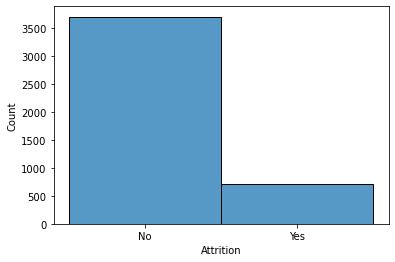

In [61]:
# Target variable
sns.histplot(df3.Attrition);

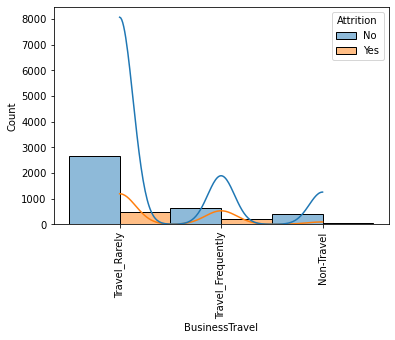

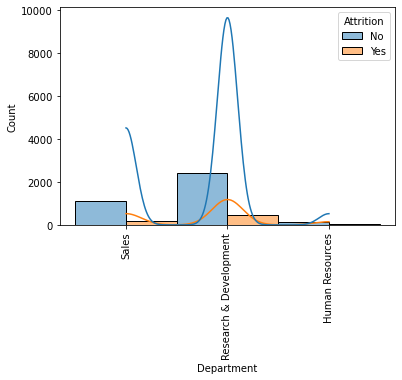

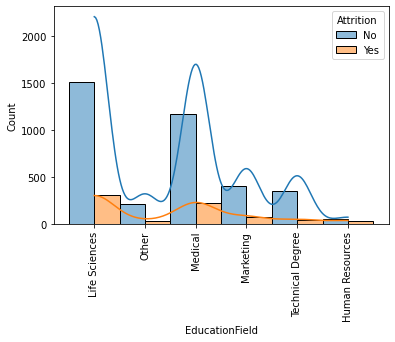

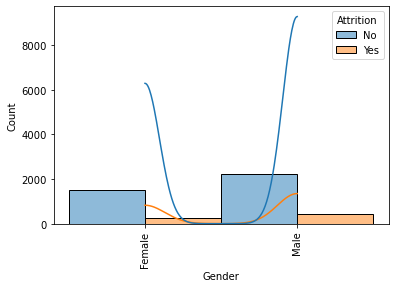

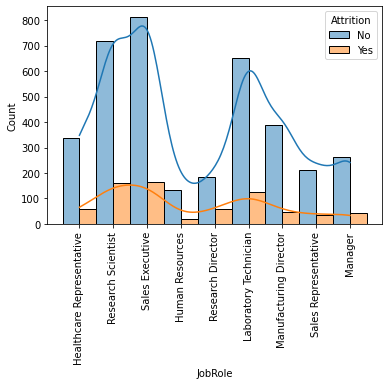

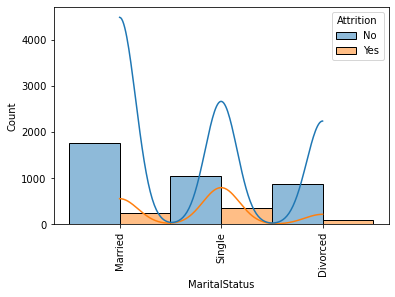

In [62]:
# Plotting histograms for categorical variables
for i, col in enumerate([ 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus']):
    plt.figure(i)
    sns.histplot(df3,x=col,hue = 'Attrition',multiple="dodge", kde=True)
    plt.xticks(rotation=90);

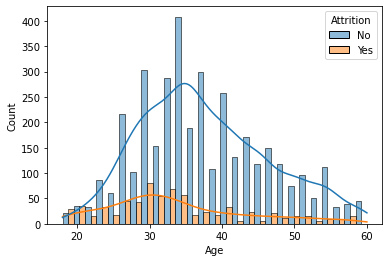

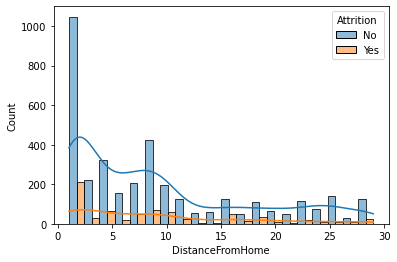

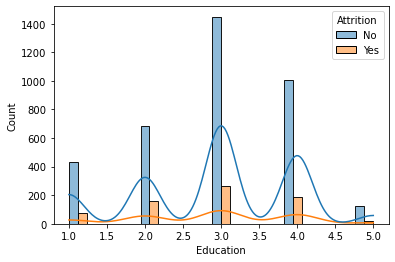

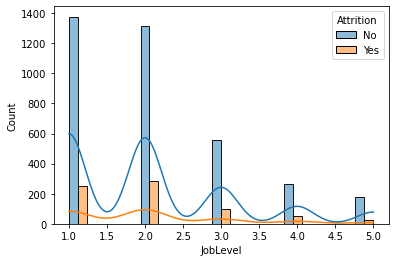

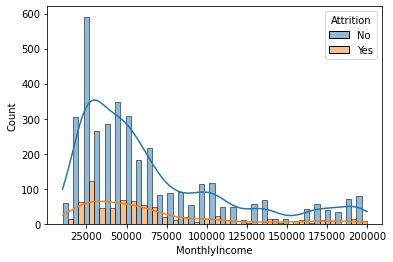

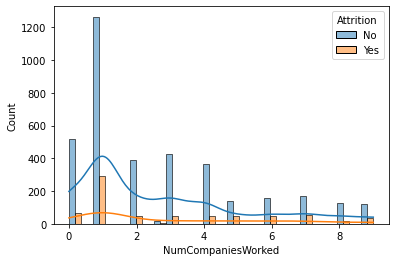

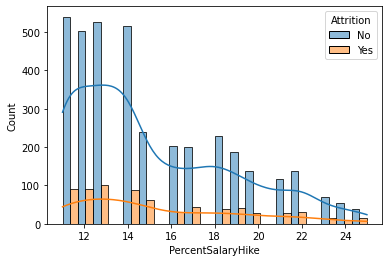

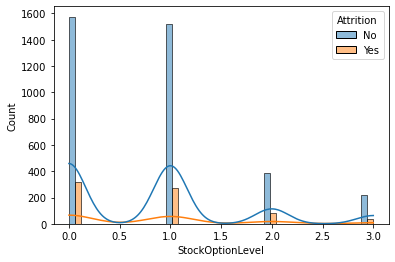

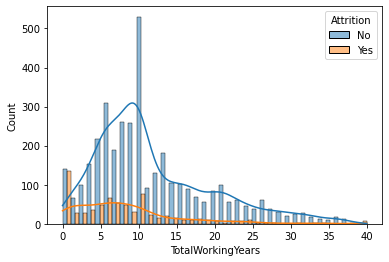

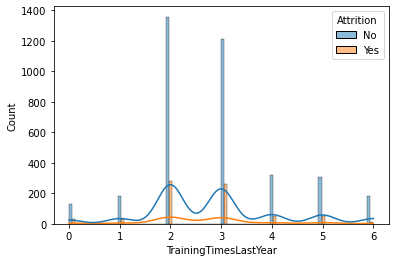

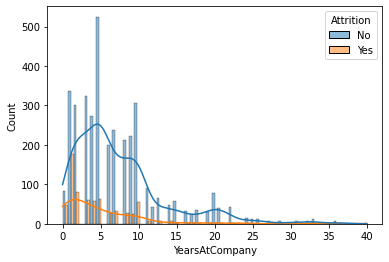

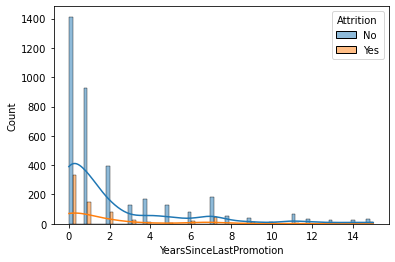

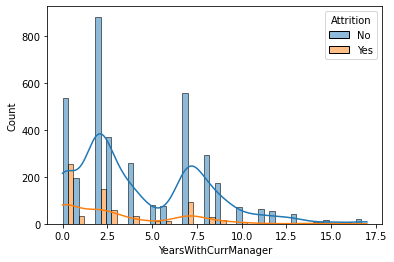

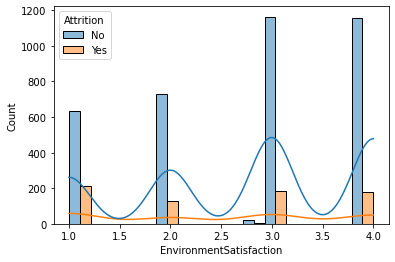

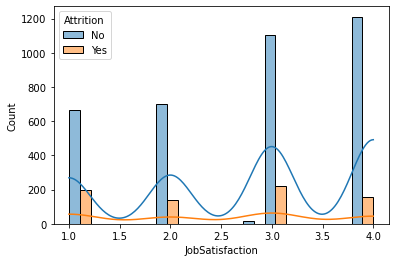

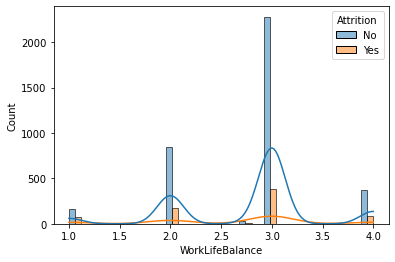

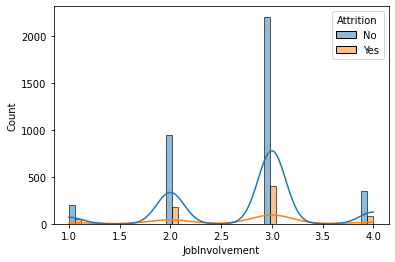

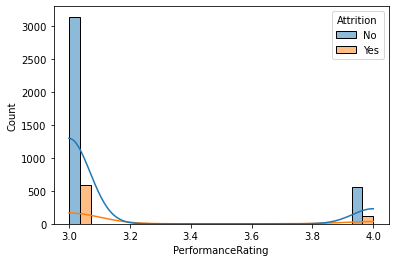

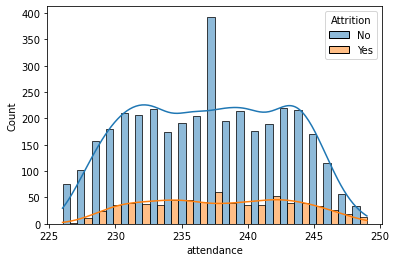

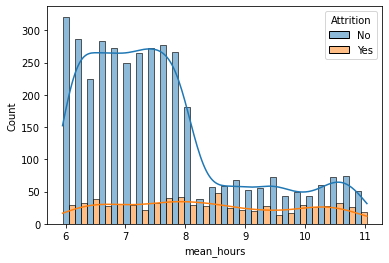

In [63]:
# Plotting histograms for numerical variables
for i, col in enumerate(['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'attendance', 'mean_hours']):
    plt.figure(i)
    sns.histplot(df3,x=col,hue = 'Attrition',multiple="dodge", kde=True);

In [68]:
# Making the target numerical
df3['Attrition'] = df3['Attrition'].replace({'Yes':1,'No':0})

In [69]:
df3['Attrition']

EmployeeID
1       0
2       1
3       0
4       0
5       0
       ..
4406    0
4407    0
4408    0
4409    0
4410    0
Name: Attrition, Length: 4410, dtype: int64

In [70]:
# Processing data based on the visualisations - mainly ordinal into categorical and some numerical into bands
# Age into bands, Education categorical, JobLevel categorical, monthlyincome into bands, Total WorkingYears into bands,
# TrainingTimes categorical, years at company into bands, environmentsat categorical, jobsat categorical,worklife cat,
# jobinv cat, perfrat cat, attendance bands, mean_hours bands (at least 2!). For speed, convert datatpyes to string (except
# mean_hours, monthly_income)

In [71]:
# Starting with a copy of the dataframe (to compare with model built on unprocessed data)
df4=df3.copy()

In [72]:
# Ordinal to categorical
df4 = df4.astype({'Age': 'str',  'Education':'str', 'JobLevel':'str', 
        'StockOptionLevel':'str',
       'TotalWorkingYears':'str', 'TrainingTimesLastYear':'str', 'YearsAtCompany':'str',
        'YearsWithCurrManager':'str',
       'EnvironmentSatisfaction':'str', 'JobSatisfaction':'str', 'WorkLifeBalance':'str',
       'JobInvolvement':'str', 'PerformanceRating':'str', 'attendance':'str'})

In [73]:
# mean_hours into 2 bands
df4['meanhrgt8'] = df4['mean_hours'].apply(lambda x: 1 if x>8 else 0)

In [74]:
df4['meanhrgt8']

EmployeeID
1       0
2       0
3       0
4       0
5       1
       ..
4406    1
4407    0
4408    0
4409    1
4410    0
Name: meanhrgt8, Length: 4410, dtype: int64

In [75]:
# Income into 10 bands
pd.cut(df4['MonthlyIncome'],10 ,retbins=True)

(EmployeeID
 1       (124030.0, 143020.0]
 2         (29080.0, 48070.0]
 3       (181000.0, 199990.0]
 4         (67060.0, 86050.0]
 5          (9900.1, 29080.0]
                 ...         
 4406      (48070.0, 67060.0]
 4407       (9900.1, 29080.0]
 4408      (29080.0, 48070.0]
 4409       (9900.1, 29080.0]
 4410      (48070.0, 67060.0]
 Name: MonthlyIncome, Length: 4410, dtype: category
 Categories (10, interval[float64]): [(9900.1, 29080.0] < (29080.0, 48070.0] < (48070.0, 67060.0] < (67060.0, 86050.0] ... (124030.0, 143020.0] < (143020.0, 162010.0] < (162010.0, 181000.0] < (181000.0, 199990.0]],
 array([  9900.1,  29080. ,  48070. ,  67060. ,  86050. , 105040. ,
        124030. , 143020. , 162010. , 181000. , 199990. ]))

In [76]:
df4['IncomeBands'] = pd.cut(df4['MonthlyIncome'],10, labels = [  '10-29',  '29-48' ,  '48-67' ,  '67-86' ,  '86-105' , '105-124' ,
        '124-143' , '143-162' , '162-181' , '181-200' ])

In [77]:
df4['IncomeBands']

EmployeeID
1       124-143
2         29-48
3       181-200
4         67-86
5         10-29
         ...   
4406      48-67
4407      10-29
4408      29-48
4409      10-29
4410      48-67
Name: IncomeBands, Length: 4410, dtype: category
Categories (10, object): ['10-29' < '29-48' < '48-67' < '67-86' ... '124-143' < '143-162' < '162-181' < '181-200']

In [78]:
# Inspect,inspect,inspect
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4410
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Age                      4410 non-null   object  
 1   Attrition                4410 non-null   int64   
 2   BusinessTravel           4410 non-null   object  
 3   Department               4410 non-null   object  
 4   DistanceFromHome         4410 non-null   int64   
 5   Education                4410 non-null   object  
 6   EducationField           4410 non-null   object  
 7   Gender                   4410 non-null   object  
 8   JobLevel                 4410 non-null   object  
 9   JobRole                  4410 non-null   object  
 10  MaritalStatus            4410 non-null   object  
 11  MonthlyIncome            4410 non-null   int64   
 12  NumCompaniesWorked       4410 non-null   float64 
 13  PercentSalaryHike        4410 non-null   int64   
 14  StockOpt

In [79]:
# Don't need these columns now!
df4 = df4.drop(columns = ['mean_hours','MonthlyIncome'])

In [80]:
# Firstly logistic regression on df3

In [81]:
# Copy of df3 for this exercise
dflog = df3.copy()

In [82]:
# Extracting the target variable and inspecting the accuracy baseline
y = dflog.pop('Attrition')
y.value_counts(normalize = True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [83]:
# Categorical back to numerical for the model to work with
X = pd.get_dummies(dflog)

In [84]:
X.head()

,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,...,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,51,6,2,1,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,31,10,1,1,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
3,32,17,4,4,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,38,2,5,3,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,...,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
5,32,10,1,1,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [85]:
# Test/train split for the model
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y, test_size=0.25, random_state=1)

In [86]:
# Scaling to make the model's life easier
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [87]:
# Defining the model
model = LogisticRegression(solver='liblinear')
list(model.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [88]:
# Gridsearch for the best result
params = {'C': np.logspace(-4, 4, 10),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False]}

gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-2,
                  verbose=1)

gs.fit(X_train, y_train)

# extract the grid search results

print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs.score(X_test, y_test))
print('Best estimator coefficients:')
print(gs.best_estimator_.coef_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters:
{'C': 0.3593813663804626, 'fit_intercept': True, 'penalty': 'l1'}
Best estimator C:
0.3593813663804626
Best estimator mean cross validated training score:
0.8572756649039495
Best estimator score on the full training set:
0.8590867856062897
Best estimator score on the test set:
0.8549410698096102
Best estimator coefficients:
[[-0.32224065 -0.0199925  -0.06117873 -0.04952415 -0.06052929  0.33768745
   0.00234594 -0.05405423 -0.55333751 -0.23142821  0.04760731  0.57859149
  -0.57094261 -0.36148827 -0.38454911 -0.2117905  -0.05786406  0.00457996
   0.00402217  0.58060157 -0.13808183  0.30295324  0.          0.15023285
   0.         -0.01043284  0.08061781  0.00373821 -0.02723235  0.
  -0.08112301 -0.03113911 -0.01414829  0.04722101 -0.02537556 -0.03245183
   0.         -0.10461665 -0.215153    0.09122315  0.          0.02692404
  -0.07806002 -0.09525725  0.          0.41853888]]


In [89]:
cmap = ListedColormap(sns.color_palette("husl", len(gs.classes_)))

In [90]:
# Extracting the model predictions
predictions_train = gs.predict(X_train)
predictions_test = gs.predict(X_test)

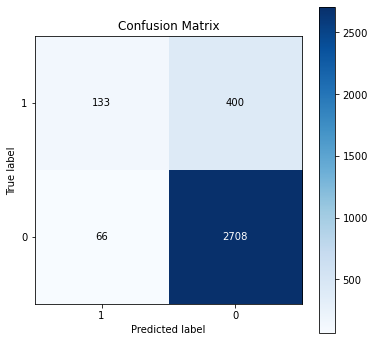

In [91]:
# Plotting train predictions (useful to check for overfitting)
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, labels=[1, 0], figsize=(6,6))
plt.show()

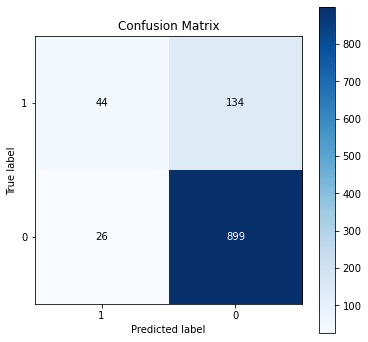

In [92]:
# Plotting train predictions
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, labels=[1, 0], figsize=(6, 6))
plt.show()

In [93]:
# Most useful results in one table
print(classification_report(y_train, predictions_train))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2774
           1       0.67      0.25      0.36       533

    accuracy                           0.86      3307
   macro avg       0.77      0.61      0.64      3307
weighted avg       0.84      0.86      0.83      3307



In [94]:
# Main results table - the results on the unseen data. Not great! Accuracy at 85% is only slightly better than 83.9% 
# baseline, f1 score of 35% for attrition of 1 is poor.
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       925
           1       0.63      0.25      0.35       178

    accuracy                           0.85      1103
   macro avg       0.75      0.61      0.64      1103
weighted avg       0.83      0.85      0.83      1103



In [95]:
# Process for finding most important variables (the higher the coefficient, the more influence it has. NB the data has 
# been scaled)
df_coef = pd.DataFrame(gs.best_estimator_.coef_[0], index = X_train.columns, columns=['coefficients'])
# calculate the absolute values of the coefficients
#df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef = df_coef.sort_values( by ='coefficients', ascending = False)
df_coef

,coefficients
mean_hours,0.580602
YearsSinceLastPromotion,0.578591
MaritalStatus_Single,0.418539
NumCompaniesWorked,0.337687
BusinessTravel_Travel_Frequently,0.302953
Department_Human Resources,0.150233
JobRole_Research Director,0.091223
EducationField_Human Resources,0.080618
YearsAtCompany,0.047607
Gender_Male,0.047221


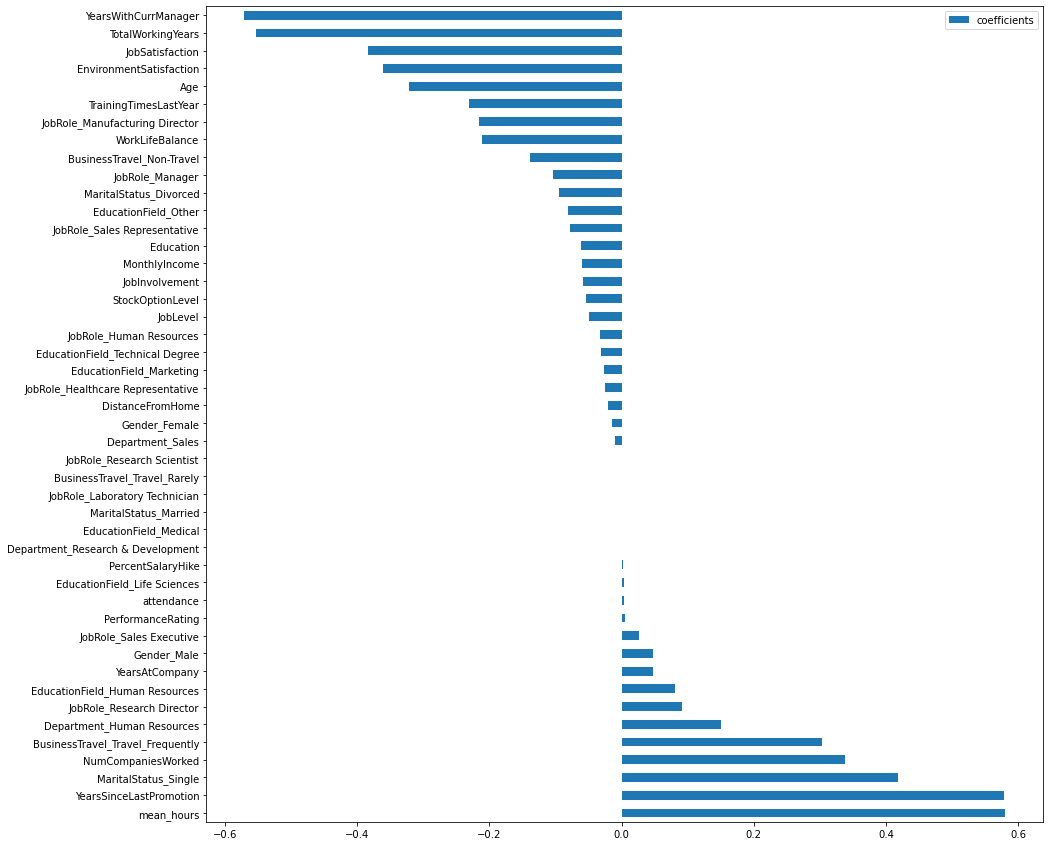

In [96]:
# Plotting the most important features.
df_coef.plot(kind='barh', figsize = (15,15));

In [97]:
# Now try on df4

In [98]:
dflog1 = df4.copy()

In [99]:
y = dflog1.pop('Attrition')
y.value_counts(normalize = True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [100]:
X = pd.get_dummies(dflog1)

In [101]:
X.head()

,DistanceFromHome,NumCompaniesWorked,PercentSalaryHike,YearsSinceLastPromotion,meanhrgt8,Age_18,Age_19,Age_20,Age_21,Age_22,Age_23,Age_24,Age_25,Age_26,Age_27,...,attendance_245,attendance_246,attendance_247,attendance_248,attendance_249,IncomeBands_10-29,IncomeBands_29-48,IncomeBands_48-67,IncomeBands_67-86,IncomeBands_86-105,IncomeBands_105-124,IncomeBands_124-143,IncomeBands_143-162,IncomeBands_162-181,IncomeBands_181-200
EmployeeID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,6,1.0,11,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,10,0.0,23,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,1.0,15,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2,3.0,11,7,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,10,4.0,12,0,1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y, test_size=0.25, random_state=1)

In [103]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [104]:
model = LogisticRegression(solver='saga', max_iter=1000)

In [105]:
params = {'C': np.logspace(-4, 2, 10),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False]}

gs1 = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-2,
                  verbose=3)

gs1.fit(X_train, y_train)

# extract the grid search results

print('Best Parameters:')
print(gs1.best_params_)
print('Best estimator C:')
print(gs1.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs1.best_score_)
print('Best estimator score on the full training set:')
print(gs1.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs1.score(X_test, y_test))
print('Best estimator coefficients:')
print(gs1.best_estimator_.coef_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters:
{'C': 0.21544346900318823, 'fit_intercept': True, 'penalty': 'l2'}
Best estimator C:
0.21544346900318823
Best estimator mean cross validated training score:
0.8869057685188148
Best estimator score on the full training set:
0.9107952827335954
Best estimator score on the test set:
0.8631006346328196
Best estimator coefficients:
[[-0.03375411  0.58928842 -0.15677364  0.70443622  0.91136715  0.06115273
   0.10565661  0.08434872  0.05523691  0.17582014  0.17226425  0.11924814
   0.10204841  0.17846992 -0.15504624  0.18438417  0.28684578  0.11637851
   0.22100418  0.11755963  0.01064059  0.01991189  0.05328304 -0.1823322
  -0.07202721 -0.3431279   0.14705134  0.01565641 -0.05301445 -0.521405
  -0.20214473  0.09886803 -0.3010359  -0.0067708  -0.08507584 -0.12599305
  -0.00540823  0.21675562 -0.12797332  0.13264421 -0.01426822 -0.39339905
   0.10456692  0.11820172 -0.0636083   0.04793056 -0.26574196 -0.17228602
  -0

In [106]:
predictions_train = gs1.predict(X_train)
predictions_test = gs1.predict(X_test)

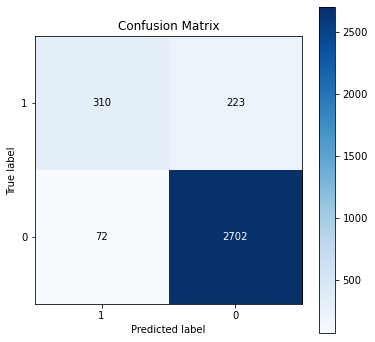

In [107]:
# Better results than before
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, labels=[1, 0], figsize=(6,6))
plt.show()

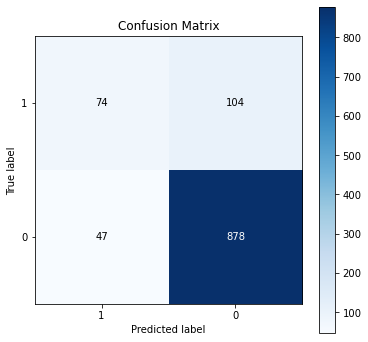

In [108]:
# Better result than before
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, labels=[1, 0], figsize=(6, 6))
plt.show()

In [109]:
print(classification_report(y_train, predictions_train))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      2774
           1       0.81      0.58      0.68       533

    accuracy                           0.91      3307
   macro avg       0.87      0.78      0.81      3307
weighted avg       0.91      0.91      0.90      3307



In [110]:
# Again better results - but not great. Accuracy at 86% compares with 85% from df3, f1 for attrition 1 significantly 
# better at 49% compared with 35% previously. Results still not great/particularly usable.
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       925
           1       0.61      0.42      0.49       178

    accuracy                           0.86      1103
   macro avg       0.75      0.68      0.71      1103
weighted avg       0.85      0.86      0.85      1103



In [111]:
df_coef = pd.DataFrame(gs1.best_estimator_.coef_[0], index = X_train.columns, columns=['coefficients'])
# calculate the absolute values of the coefficients
#df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef = df_coef.sort_values( by ='coefficients', ascending = False)
df_coef

,coefficients
meanhrgt8,0.911367
YearsSinceLastPromotion,0.704436
NumCompaniesWorked,0.589288
EnvironmentSatisfaction_1.0,0.410606
MaritalStatus_Single,0.405257
...,...
JobSatisfaction_4.0,-0.399055
YearsWithCurrManager_13,-0.417443
Age_42,-0.521405
YearsWithCurrManager_12,-0.541591


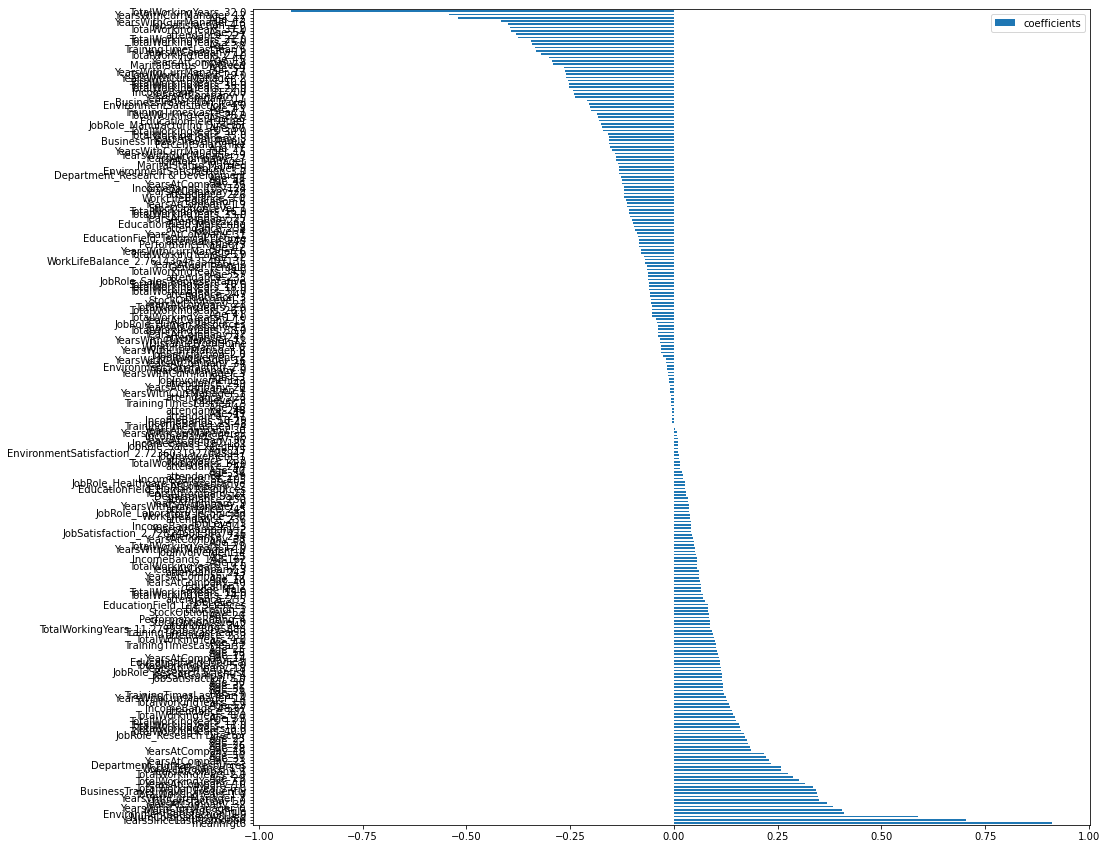

In [112]:
# More categoricals means more coefficients - lower down we chart only the most significant ones to make the chart readable.
df_coef.plot(kind='barh', figsize = (15,15));

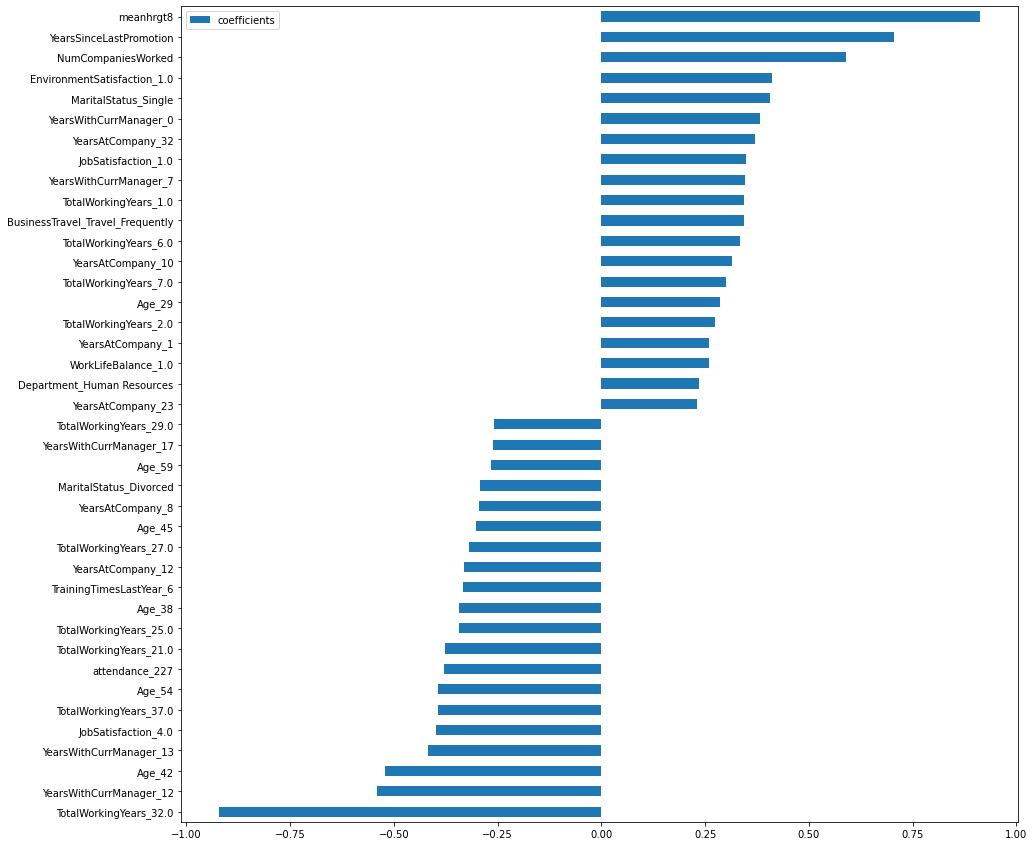

In [113]:
# Most interesting  - working over 8 hours on average is the most significant indicator!
pd.concat([df_coef.sort_values( by ='coefficients' )[:20],df_coef.sort_values( by ='coefficients' )[-20:]], axis = 0).plot(kind='barh', figsize = (15,15));

In [114]:
# and now for xgboost (using df4 as better results obtained)

In [177]:
dflxgb = df4.copy()

In [178]:
y = dflxgb.pop('Attrition')
y.value_counts(normalize = True)

0    0.838776
1    0.161224
Name: Attrition, dtype: float64

In [179]:
X = pd.get_dummies(dflxgb)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y, test_size=0.25, random_state=1)

In [181]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [120]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [121]:
predictions_train = xgb_model.predict(X_train)
predictions_test = xgb_model.predict(X_test)

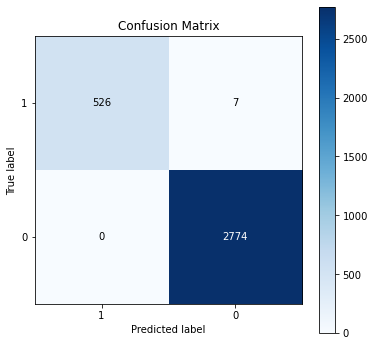

In [122]:
# These results are much more encouraging (unless we're overfitting)
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, labels=[1, 0], figsize=(6,6))
plt.show()

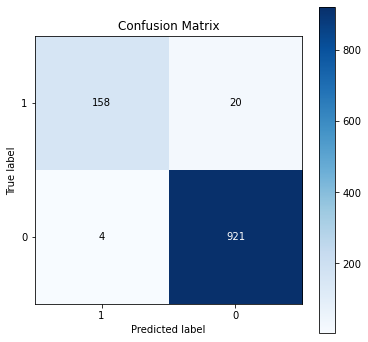

In [123]:
# We're not overfitting! woo-hoo
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, labels=[1, 0], figsize=(6,6))
plt.show()

In [124]:
print(classification_report(y_train, predictions_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2774
           1       1.00      0.99      0.99       533

    accuracy                           1.00      3307
   macro avg       1.00      0.99      1.00      3307
weighted avg       1.00      1.00      1.00      3307



In [125]:
# Great results - 98% accuracy and 93% f1 for attrition 1 - seem like results we can use.
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       925
           1       0.98      0.89      0.93       178

    accuracy                           0.98      1103
   macro avg       0.98      0.94      0.96      1103
weighted avg       0.98      0.98      0.98      1103



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

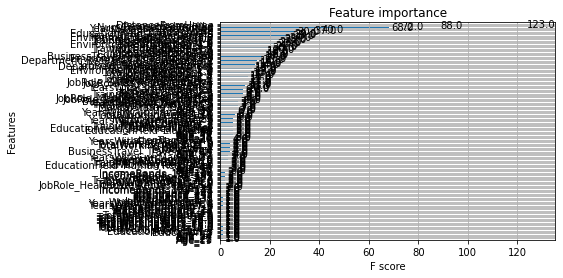

In [126]:
# We need to extract the most relevant features. NB all coefficients in this model are positive...
xgb.plot_importance(xgb_model)

In [127]:
df_coef1 = pd.DataFrame(xgb_model.feature_importances_, index = xgb_model.feature_names_in_, columns=['coefficients'])

In [128]:
df_coef1

,coefficients
DistanceFromHome,0.005532
NumCompaniesWorked,0.005631
PercentSalaryHike,0.004839
YearsSinceLastPromotion,0.006557
meanhrgt8,0.015874
...,...
IncomeBands_105-124,0.001012
IncomeBands_124-143,0.002937
IncomeBands_143-162,0.000000
IncomeBands_162-181,0.025381


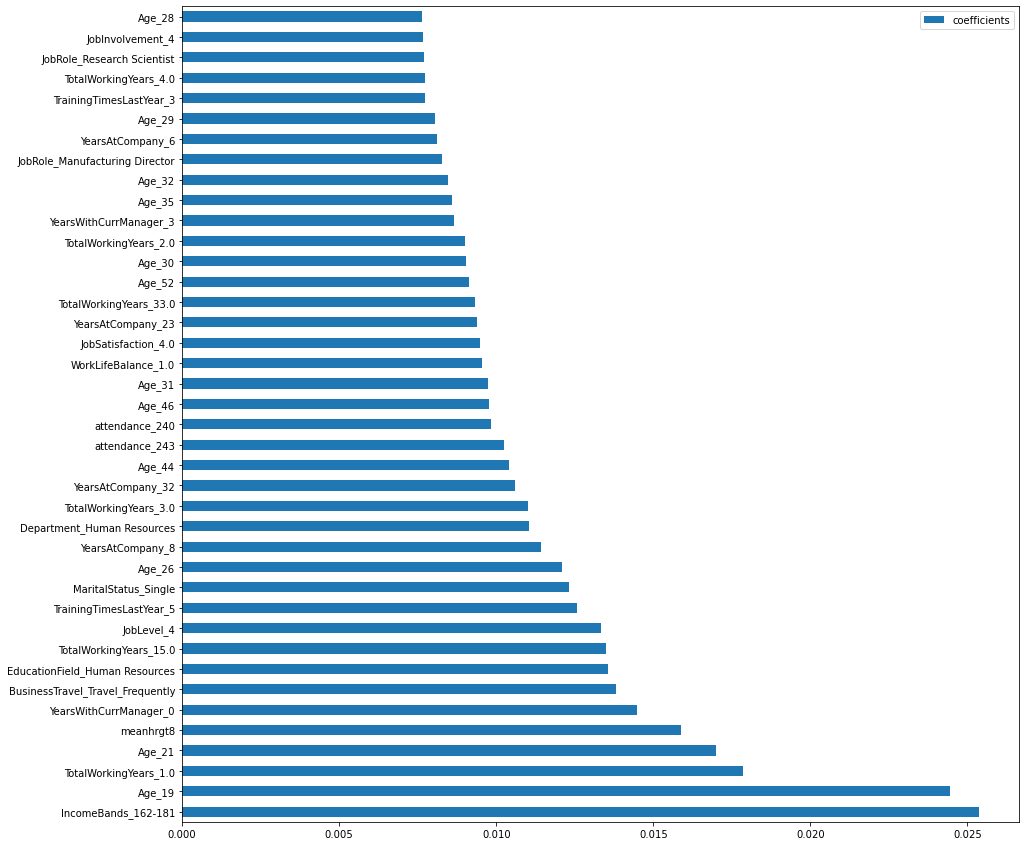

In [129]:
# More nuanced features - it's not only the more than 8 hours average hours, but also age, short length of time with co
# and short time with current manager that have some effect. Note how small the numbers are - SHAPLEY values are additive.

df_coef1.sort_values( by ='coefficients' , ascending=False)[:40].plot(kind='barh', figsize = (15,15));

In [126]:
# Looking at SHAP values for explainability (not absolutely necessary as data was scaled, but useful and interesting
# as a comparative view - also shows in more detail the positive/negative aspects of features in summary plot)

  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4


In [130]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


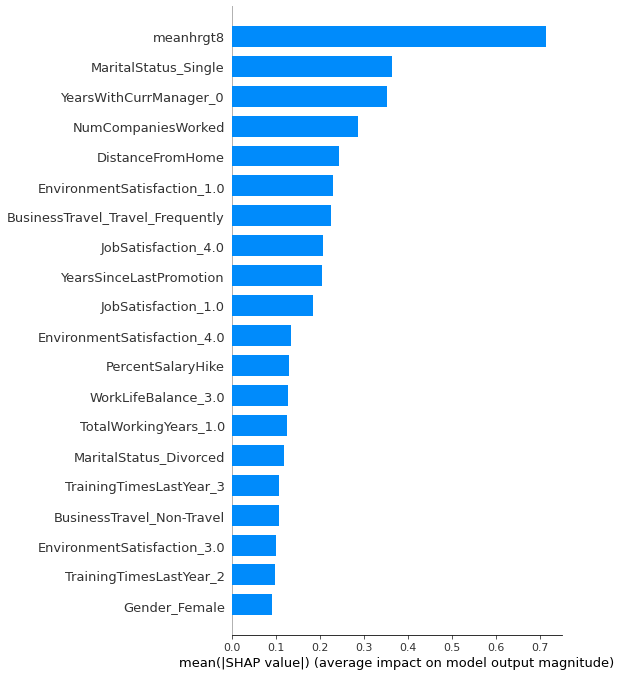

In [131]:
# This shows the average importance for each feature for all predictions
shap.summary_plot(shap_values, X_test, plot_type="bar")

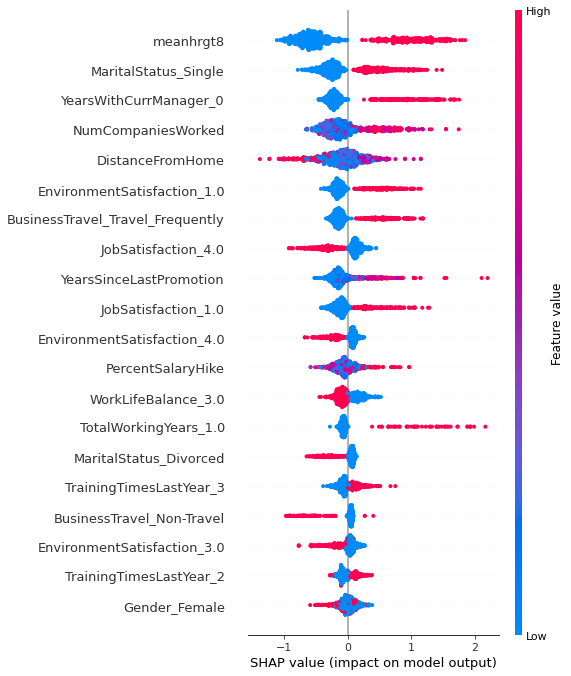

In [132]:
# This shows the impact of each feature for each prediction
# To get an overview of which features are most important for a model we can plot the SHAP values of every feature for 
# every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values 
# to show the distribution of the impacts each feature has on the model output. The color represents the feature value 
# (red high, blue low). This reveals for example that  meanhrgt8 (mean hours greater than 8) 
# increases the chance of attrition - as does being single (MaritalStatus_Single).
shap.summary_plot(shap_values, X_test)

In [ ]:
# Much better! Now for optimisation using bayesian optimiser.

In [135]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")

In [138]:
print(model.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': 'auc', 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [190]:
xgbs1 = BayesSearchCV(XGBClassifier(objective="binary:logistic", random_state=42,eval_metric = 'auc'),
        {          
          'param_gamma': Real(1e-6, 1e+1, prior='log-uniform'), 
          #'eval_metric': 'auc',
          #'grow_policy': 'depthwise', 
          #'interaction_constraints': '', 
          'param_learning_rate': Real(1e-6, 0.3, prior='uniform'), 
          #'max_bin': 256, 
          #'max_cat_to_onehot': 4, 
          #'max_delta_step': 0, 
          'param_max_depth': Integer(3,10), 
          #'max_leaves': 0, 
          #'min_child_weight': 1, 
          #'monotone_constraints': '()', 
          #'num_parallel_tree': 1, 
          #'predictor': 'auto', 
          #'random_state': 42, 
          #'param_reg_alpha': Real(1e-6, 1e+1, prior='log-uniform'), 
          #'param_reg_lambda': Real(1e-6, 1e+1, prior='log-uniform'), 
          #'sampling_method': 'uniform', 
          #'param_scale_pos_weight': Real(1e-6, 1e+1, prior='log-uniform'), 
          #'param_subsample': Real(1e-6, 1e+1, prior='log-uniform'), 
          #'tree_method': 'exact', 
          #'validate_parameters': 1 
         },
        n_iter = 9,
        #scoring = 'f1',
        cv=3,
        n_jobs=-2,
        verbose=3)
xgbs1.fit(X_train, y_train)

print("val. score: %s" % xgbs1.best_score_)
print("test score: %s" % xgbs1.score(X_test, y_test))
print("best params: %s" % str(xgbs1.best_params_))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[08:56:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "param_gamma", "param_learning_rate", "param_max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


val. sc

In [191]:
predictions_train = xgbs1.predict(X_train)
predictions_test = xgbs1.predict(X_test)

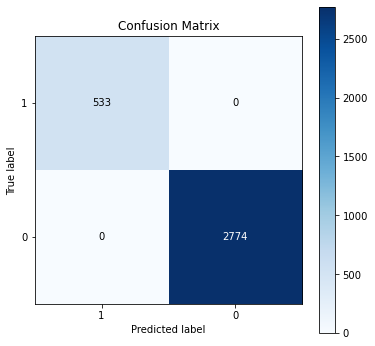

In [192]:
# Potentially overfitting
skplt.metrics.plot_confusion_matrix(y_train, predictions_train, labels=[1, 0], figsize=(6,6))
plt.show()

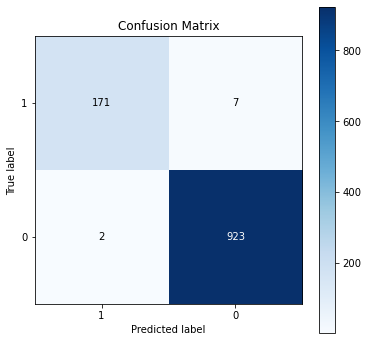

In [193]:
# Improved results - Also see classification report below (97% f1 score for minority class) - overfitting not a problem.
skplt.metrics.plot_confusion_matrix(y_test, predictions_test, labels=[1, 0], figsize=(6,6))
plt.show()

In [194]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       925
           1       0.99      0.96      0.97       178

    accuracy                           0.99      1103
   macro avg       0.99      0.98      0.98      1103
weighted avg       0.99      0.99      0.99      1103



In [196]:
# Probabilities for metrics plotting.
predicted_probas = xgbs1.predict_proba(X_test)

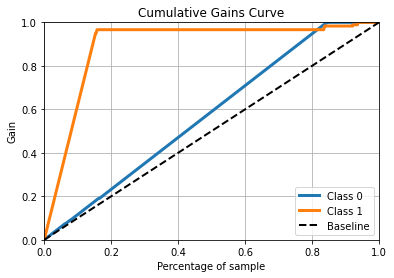

In [199]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain(y_test,predicted_probas);

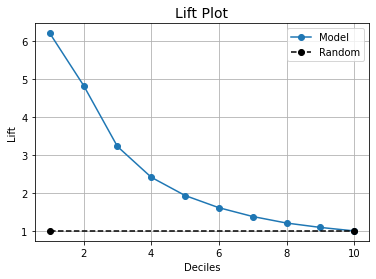

In [203]:
# A different approach - using kds package for lift and gain
kds.metrics.plot_lift(y_test, predicted_probas[:,1])

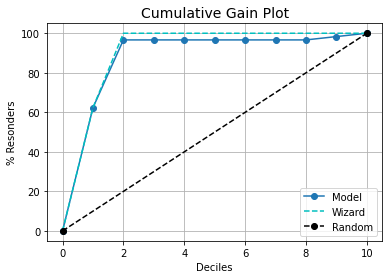

In [204]:
# Cumulative gain plot (wizard is theoretical maximum performing model)
kds.metrics.plot_cumulative_gain(y_test,predicted_probas[:,1])

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

,decile,prob_min,prob_max,prob_avg,cnt_cust,cnt_resp,cnt_non_resp,cnt_resp_rndm,cnt_resp_wiz,resp_rate,cum_cust,cum_resp,cum_resp_wiz,cum_non_resp,cum_cust_pct,cum_resp_pct,cum_resp_pct_wiz,cum_non_resp_pct,KS,lift
0,1,0.906,0.998,0.953,111.0,111.0,0.0,17.8,111,100.000,111.0,111.0,111,0.0,10.063,62.360,62.36,0.000,62.360,6.197
1,2,0.064,0.906,0.526,110.0,61.0,49.0,17.8,67,55.455,221.0,172.0,178,49.0,20.036,96.629,100.00,5.297,91.332,4.823
2,3,0.023,0.063,0.037,110.0,0.0,110.0,17.8,0,0.000,331.0,172.0,178,159.0,30.009,96.629,100.00,17.189,79.440,3.220
3,4,0.013,0.022,0.018,111.0,0.0,111.0,17.8,0,0.000,442.0,172.0,178,270.0,40.073,96.629,100.00,29.189,67.440,2.411
4,5,0.008,0.013,0.010,110.0,0.0,110.0,17.8,0,0.000,552.0,172.0,178,380.0,50.045,96.629,100.00,41.081,55.548,1.931
5,6,0.005,0.008,0.006,110.0,0.0,110.0,17.8,0,0.000,662.0,172.0,178,490.0,60.018,96.629,100.00,52.973,43.656,1.610
6,7,0.003,0.005,0.004,111.0,0.0,111.0,17.8,0,0.000,773.0,172.0,178,601.0,70.082,96.629,100.00,64.973,31.656,1.379
7,8,0.002,0.003,0.002,110.0,0.0,110.0,17.8,0,0.000,883.0,172.0,178,711.0,80.054,96.629,100.00,76.865,19.764,1.207
8,9,0.001,0.002,0.001,110.0,3.0,107.0,17.8,0,2.727,993.0,175.0,178,818.0,90.027,98.315,100.00,88.432,9.883,1.092
9,10,0.000,0.001,0.000,110.0,3.0,107.0,17.8,0,2.727,1103.0,178.0,178,925.0,100.000,100.000,100.00,100.000,0.000,1.000


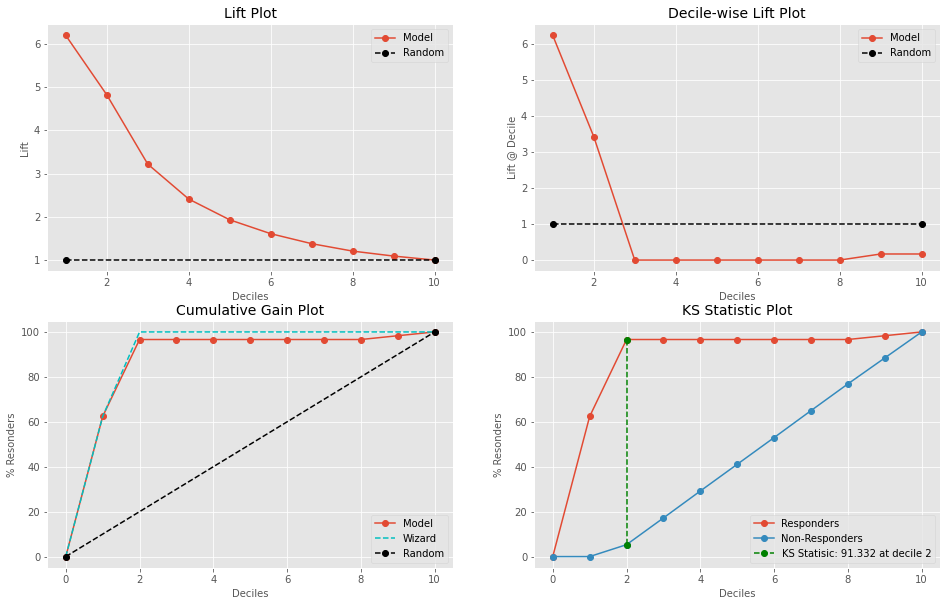

In [209]:
# All together...
kds.metrics.report(y_test,predicted_probas[:,1], plot_style='ggplot')